<a href="https://colab.research.google.com/github/arianesannt/Tech_challenge_fase2/blob/main/Tech_challenge_Ibovespa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
# No colab não precisa instalar a Prophet, apenas a biblioteca yfinance

#!pip install yfinance --upgrade --no-cache-dir

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader.data as web
yf.pdr_override()


# Adequação do dataset

In [3]:
# buscando dados da Ibovespa diretamente da web

dados = web.get_data_yahoo('^BVSP', period='15y')

[*********************100%%**********************]  1 of 1 completed


In [4]:
dados

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-22,38543.0,38845.0,37255.0,37894.0,37894.0,1744600
2009-01-23,37891.0,38660.0,36744.0,38132.0,38132.0,1433000
2009-01-26,38130.0,39065.0,37831.0,38509.0,38509.0,1493800
2009-01-27,38511.0,39025.0,38422.0,38699.0,38699.0,1423800
2009-01-28,38704.0,40438.0,38704.0,40227.0,40227.0,2132400
...,...,...,...,...,...,...
2024-01-16,131515.0,131517.0,129147.0,129294.0,129294.0,11911300
2024-01-17,129293.0,129296.0,128312.0,128524.0,128524.0,9952500
2024-01-18,128524.0,129047.0,127316.0,127316.0,127316.0,12460800


In [5]:
# para usar o prophet, vou precisar somente da data e da coluna "adj close", que são os preços ajustados

dados = dados['Adj Close']
dados

Date
2009-01-22     37894.0
2009-01-23     38132.0
2009-01-26     38509.0
2009-01-27     38699.0
2009-01-28     40227.0
                ...   
2024-01-16    129294.0
2024-01-17    128524.0
2024-01-18    127316.0
2024-01-19    127636.0
2024-01-22    126602.0
Name: Adj Close, Length: 3711, dtype: float64

In [6]:
# o prophet só trabalha com Dataframe, então precisa transformar
type(dados)

pandas.core.series.Series

In [7]:
dados = pd.DataFrame(dados)
dados

,Adj Close
Date,
2009-01-22,37894.0
2009-01-23,38132.0
2009-01-26,38509.0
2009-01-27,38699.0
2009-01-28,40227.0
...,...
2024-01-16,129294.0
2024-01-17,128524.0
2024-01-18,127316.0


In [8]:
dados.reset_index('Date', inplace=True)
dados

,Date,Adj Close
0,2009-01-22,37894.0
1,2009-01-23,38132.0
2,2009-01-26,38509.0
3,2009-01-27,38699.0
4,2009-01-28,40227.0
...,...,...
3706,2024-01-16,129294.0
3707,2024-01-17,128524.0
3708,2024-01-18,127316.0
3709,2024-01-19,127636.0


In [9]:
# o prophet só usa duas colunas que é ds e y, sendo ds a data e y o alvo
dados.columns = ['ds', 'y']
dados

,ds,y
0,2009-01-22,37894.0
1,2009-01-23,38132.0
2,2009-01-26,38509.0
3,2009-01-27,38699.0
4,2009-01-28,40227.0
...,...,...
3706,2024-01-16,129294.0
3707,2024-01-17,128524.0
3708,2024-01-18,127316.0
3709,2024-01-19,127636.0


In [10]:
#verificando se os dados estao no tipo correto para criação do modelo com prophet e no caso estão ok
dados.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [11]:
# separando a base em pre-covid e pos-covid

dados2 = dados.copy()
dados2['pre_covid'] = pd.to_datetime(dados2['ds']) < pd.to_datetime('2020-03-16')
dados2['pos_covid'] = ~dados2['pre_covid']

In [12]:
dados2

,ds,y,pre_covid,pos_covid
0,2009-01-22,37894.0,True,False
1,2009-01-23,38132.0,True,False
2,2009-01-26,38509.0,True,False
3,2009-01-27,38699.0,True,False
4,2009-01-28,40227.0,True,False
...,...,...,...,...
3706,2024-01-16,129294.0,False,True
3707,2024-01-17,128524.0,False,True
3708,2024-01-18,127316.0,False,True
3709,2024-01-19,127636.0,False,True


# Criando o modelo com Prophet

In [13]:
# usando sklearn vou criar meu conjunto de treino e meu conjunto de teste
# obs: shuffle=False significa que eu não quero embaralhar meus dados, quero que fique na ordem

dados_treino, dados_teste = train_test_split(dados2, test_size=0.3, shuffle=False)

In [14]:
dados_treino

,ds,y,pre_covid,pos_covid
0,2009-01-22,37894.0,True,False
1,2009-01-23,38132.0,True,False
2,2009-01-26,38509.0,True,False
3,2009-01-27,38699.0,True,False
4,2009-01-28,40227.0,True,False
...,...,...,...,...
2592,2019-07-23,103704.0,True,False
2593,2019-07-24,104120.0,True,False
2594,2019-07-25,102655.0,True,False
2595,2019-07-26,102819.0,True,False


In [15]:
dados_teste

,ds,y,pre_covid,pos_covid
2597,2019-07-30,102933.0,True,False
2598,2019-07-31,101812.0,True,False
2599,2019-08-01,102126.0,True,False
2600,2019-08-02,102674.0,True,False
2601,2019-08-05,100098.0,True,False
...,...,...,...,...
3706,2024-01-16,129294.0,False,True
3707,2024-01-17,128524.0,False,True
3708,2024-01-18,127316.0,False,True
3709,2024-01-19,127636.0,False,True


In [16]:
# colocando numa variavel a qnt de linhas dos dados de teste para automatizar o modelo
period = dados_teste.shape[0]

In [17]:
# criando um modelo com o prophet
modelo = Prophet(seasonality_mode='additive', daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)

# adicionando os feriados
modelo.add_country_holidays(country_name='BR')

In [18]:
modelo.add_seasonality(
    name='daily_pre_covid',
    period=7,
    fourier_order=1,
    condition_name='pre_covid',
)
modelo.add_seasonality(
    name='daily_pos_covid',
    period=7,
    fourier_order=1,
    condition_name='pos_covid',
);

In [19]:
# treinando o modelo
modelo.fit(dados_treino)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwn70jyth/73iuxg_h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwn70jyth/f6samo6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=683', 'data', 'file=/tmp/tmpwn70jyth/73iuxg_h.json', 'init=/tmp/tmpwn70jyth/f6samo6s.json', 'output', 'file=/tmp/tmpwn70jyth/prophet_modelkklf22za/prophet_model-20240123111948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:19:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:19:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [20]:
# criando parametro de predição futura (quantos dias o modelo deve prever)
futuro = modelo.make_future_dataframe(freq='D', periods=period)
futuro['pre_covid'] = pd.to_datetime(futuro['ds']) < pd.to_datetime('2020-03-16')
futuro['pos_covid'] = ~futuro['pre_covid']

In [21]:
# vou criar uma previsão com base no modelo que eu treinei
previsao_teste = modelo.predict(futuro)


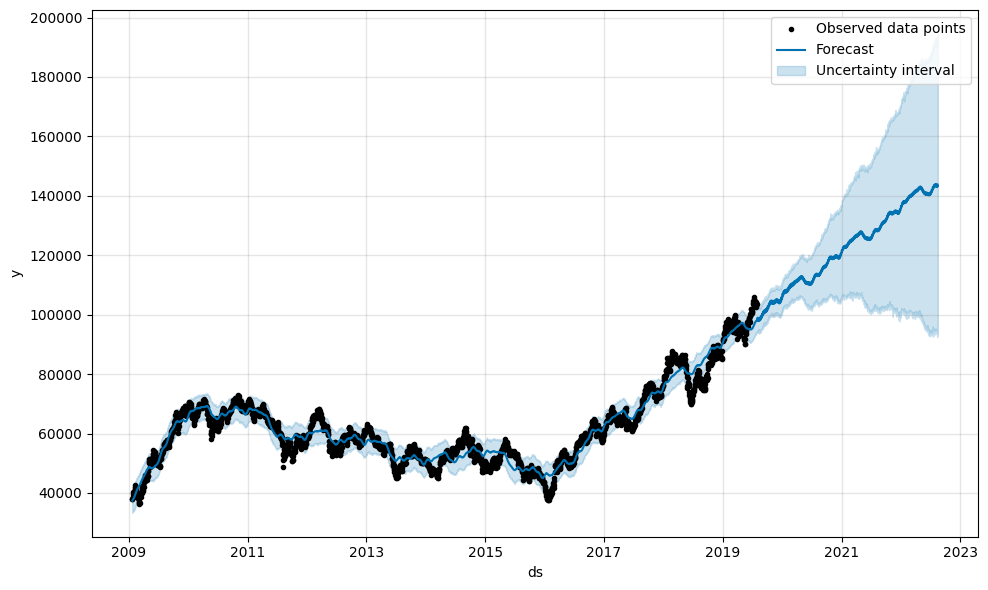

In [22]:
modelo.plot(previsao_teste)
plt.legend()
plt.show()

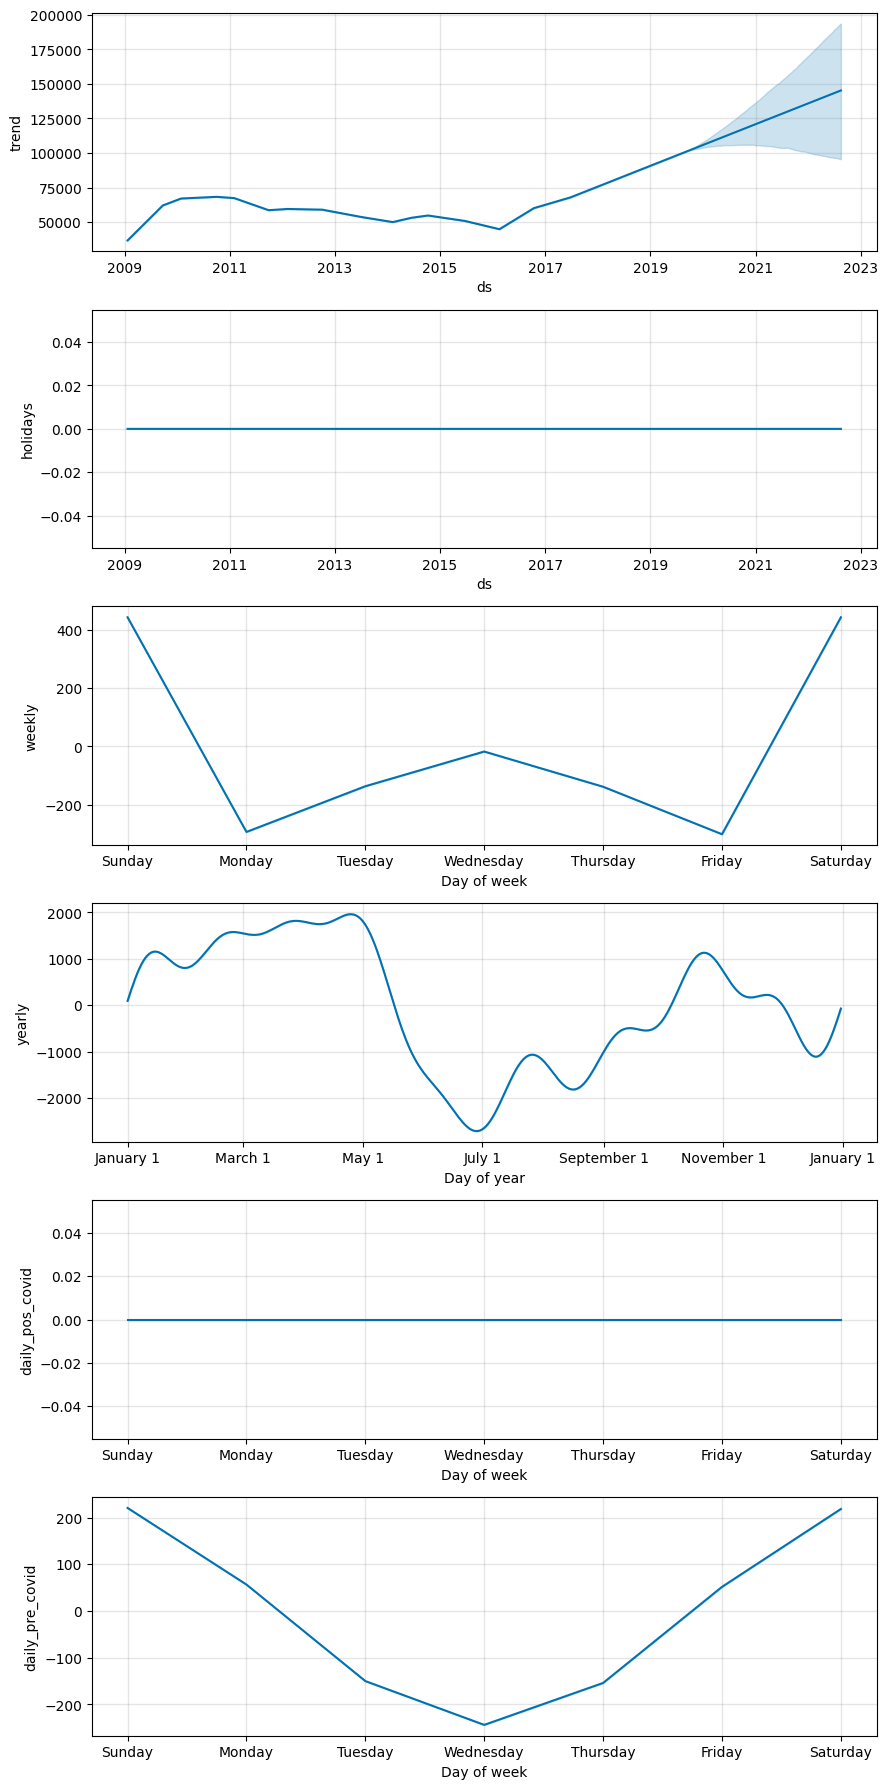

In [23]:
modelo.plot_components(previsao_teste)
plt.show()